# HW09
### 評分標準：
 - 17.1 每個項目(小題or檢定)2%，其餘題目每個項目3%
 - 有錯的部分扣1分，扣到該項目扣完為止。
 
### 批改符號說明：
 - show them/ not clear 表說明不夠清楚，e.g. coefficient的檢驗沒有明確說明p-value的值
 - 17.9 or 17.15 在(a)小題處被畫一個大圈-3分：沒有畫散佈圖
 
### 常見錯誤：
 - 16.117 是算 residual 而不是 standard residual
 
 - 16.133/ 17.1/ 17.9/ 17.15 沒有畫散佈圖
 - 16.133/ 17.1/ 17.9/ 17.15 畫了散佈圖，沒有說明你判斷該圖是否有線性關係 (但這次只有16.133有扣分)
 - 16.133 沒有做 residual analysis：雖題目沒有要求，但本次作業老師要求要完整做完7步驟
 - 16.133 Run Test n1, n2 皆< 20 ，應利用run test 表檢查 rejected region，而非用常態方法。
 - 16.133(d) 因為檢驗完發現為非線性關係且R^2過低，應無法使用此模型。
 
 - 17.1(h)(i) 注意資料與題目單位不同


In [1]:
#載入所需函示庫
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 60
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import statsmodels

import math
import statistics


In [2]:
def Normality(SD):
    print('Normality test for errors using Shapiro Test')
    print(' - H0: Errors are normally distributed.')
    print(' - H1: Errors are not normally distributed.\n')
    stat, p = stats.shapiro(SD)
    print('pvalue of Shapiro Test =', p)
    if p < 0.05:
        print('\nSince p-value < 0.05, we reject H0 and conclude errors are not normally distributed.')
    else:
        print('\nSince p-value > 0.05, we do not reject H0 and we may conclude errors are normally distributed.')

In [3]:
def Homoscedasticity(data, xlabel):
    print('Homoscedasticity Test')
    print(' - H0: Homoscedasticity')
    print(' - H1: Heteroscedasticity\n')
    y_pre = data[:, 2]
    SD = data[:, 10]
    plt.plot(y_pre, SD, 'o', color = 'gray')
    plt.axhline(y=0, color = 'blue')
    plt.axhline(y=2, color = 'red')
    plt.axhline(y=-2, color = 'red')
    plt.title('Standardized Residual Plot')
    plt.xlabel(xlabel)
    plt.ylabel('Standardized Residual')
    plt.show()


In [4]:
def Randomness(SD):
    print('Randomness Test using Runs Test')
    print(' - H0: Randomness exists.')
    print(' - H1: Randomness does not exist\n')
    
    SD_median = statistics.median(SD)
    
    runs, n1, n2 = 1, 0, 0
    if(SD[0]) >= SD_median:
        n1 += 1   
    else:
        n2 += 1     
    # Checking for start of new run 
    for i in range(len(SD)): 
        # no. of runs 
        if (SD[i] >= SD_median and SD[i-1] < SD_median) or (SD[i] < SD_median and SD[i-1] >= SD_median):
            runs += 1  
            # print(i, runs)
        # no. of positive values 
        if(SD[i]) >= SD_median: 
            n1 += 1   
        # no. of negative values 
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    if n1>20 or n2>20:
        print('\nruns_exp = ', runs_exp)
        print('stan_dev = ', stan_dev)
        print('z = ', z)
        print('pval_z = ', pval_z)
        
        if pval_z < 0.05:
            print('\nSince p-value < 0.05, we reject H0 and conclude randomness does not exist.')
        else:
            print('\nSince p-value > 0.05, we do not reject H0 and we may conclude randomness exists.')
    else:
        print('Since both n1 and n2 < 20, we check the Run Test table.')

In [5]:
def Outlier(SD):
    df = pd.DataFrame(SD,columns = ['SD'])
    filter = (df['SD'] < -2) | (df['SD'] > 2)
    outliers = df['SD'].loc[filter]
    ids = outliers.index
    ids = [n+1 for n in ids]
    
    print("Outliers by SD = \n")
    print(outliers)
    
    if len(ids)== 0:
        print("\nThere isnt any oulier.")
    else:
        print("\nSample", ids, "are outliers.")

In [6]:
def Influential(x_data, y_data):
    x_data = x_data.values
    y_data = y_data.values
    cov_mat = np.cov(y_data, x_data)
    x_data_bar = x_data.mean()
    data_nobs = len(x_data)
    h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat[1,1]
    df = pd.DataFrame(h_val,columns = ['hi'])
    filter = (df['hi'] > 6 / data_nobs )
    influs = df['hi'].loc[filter]
    ids = influs.index
    ids = [n+1 for n in ids]
    
    print("Influential Observations by hi = \n")
    print(influs)
    
    if len(ids)== 0:
        print("\nThere isnt any influential observation.")
    else:
        print("\nSample", ids, "are influential observations.")


In [7]:
def CI_PI_regression(xdata, yval, x1, a):
    
    X_data_T = xdata.T
    X_data2 = sm.add_constant(X_data_T)
    olsmod = sm.OLS(yval, X_data2)
    result_reg = olsmod.fit()
    y_head = np.dot(result_reg.params, x1)
    
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    core1 = (result_reg.mse_resid * np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1))) ** 0.5

    lower_bound = y_head +  t_minus * core1
    upper_bound = y_head +  t_plus * core1
    
    core2 = (result_reg.mse_resid * (1 + np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1)))) ** 0.5
    lower_bound2 = y_head +  t_minus * core2
    upper_bound2 = y_head +  t_plus * core2
    
    CI = [lower_bound, upper_bound]
    PI = [lower_bound2, upper_bound2]
    return CI, PI

## 16.117 (12%)  
### (Predicted y 3%, Residuals 3%, Outlier 3%, Influential observations 3%)

In [8]:
df16_5 = pd.read_excel('Xr16-05.xlsx')
df16_result1 = smf.ols('Beers~ Temperature', data=df16_5).fit()
# Inspect the results
b1_1 = df16_result1.params[1]
b0_1 = df16_result1.params[0]
print("Estimated model: y = %0.4f + %0.4f x" % (b0_1, b1_1))

Estimated model: y = -100678.1723 + 1513.3276 x


In [9]:
df16_5["Predicted y"] = b0_1 + b1_1 * df16_5["Temperature"]
df16_5["Residuals"] = df16_5["Beers"] - df16_5["Predicted y"] 
df16_5

,Temperature,Beers,Predicted y,Residuals
0,80,20533,20388.036197,144.963803
1,68,1439,2228.104926,-789.104926
2,78,13829,17361.380985,-3532.380985
3,79,21286,18874.708591,2411.291409
4,87,30985,30981.329439,3.670561
5,74,17187,11308.070561,5878.929439
6,86,30240,29468.001833,771.998167
7,92,37596,38547.967468,-951.967468
8,77,9610,15848.053379,-6238.053379
9,84,28742,26441.346621,2300.653379


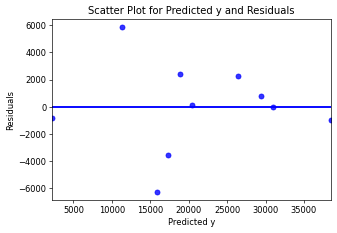

In [10]:
_ = sns.regplot(x='Predicted y', y= 'Residuals', data = df16_5, color = 'b', ci = None)
plt.title('Scatter Plot for Predicted y and Residuals')
plt.xlabel('Predicted y')
plt.ylabel('Residuals')
plt.show()

In [11]:
st5, data5, ss5 = sso.summary_table(df16_result1, alpha=0.05)
SD5 = data5[:, 10]
Outlier(SD5)

Outliers by SD = 

Series([], Name: SD, dtype: float64)

There isnt any oulier.


In [12]:
Influential(df16_5["Temperature"],df16_5["Beers"])

Influential Observations by hi = 

Series([], Name: hi, dtype: float64)

There isnt any influential observation.


## 16.127 (15%)
### (Normality 3%, Homoscedasticity 3%, Randomness 3%, Outlier 3%, Influential observations 3%)

In [13]:
df16_15 = pd.read_excel('Xr16-15.xlsx')
df16_result2 = smf.ols('Food~ Income', data=df16_15).fit()
st15, data15, ss15 = sso.summary_table(df16_result2, alpha=0.05)
SD15 = data15[:, 10]

In [14]:
Normality(SD15)

Normality test for errors using Shapiro Test
 - H0: Errors are normally distributed.
 - H1: Errors are not normally distributed.

pvalue of Shapiro Test = 0.520470380783081

Since p-value > 0.05, we do not reject H0 and we may conclude errors are normally distributed.


Homoscedasticity Test
 - H0: Homoscedasticity
 - H1: Heteroscedasticity



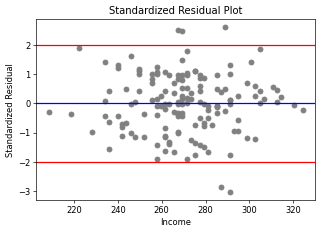

In [15]:
Homoscedasticity(data15, "Income")

According to the figure, we do not rejected H0.  
We can assume that the variation is constant and the mean is around 0.

In [16]:
Randomness(SD15)

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  77
n1 =  75
n2 =  76

runs_exp =  76.49668874172185
stan_dev =  6.1233179035675915
z =  0.08219583993587927
pval_z =  0.9344909815035417

Since p-value > 0.05, we do not reject H0 and we may conclude randomness exists.


In [17]:
Outlier(SD15)

Outliers by SD = 

22    -2.860008
75     2.498397
115   -3.015479
120    2.466531
144    2.615022
Name: SD, dtype: float64

Sample [23, 76, 116, 121, 145] are outliers.


In [18]:
Influential(df16_15["Income"],df16_15["Food"])

Influential Observations by hi = 

4     0.050967
9     0.044775
41    0.064161
51    0.047319
67    0.041397
Name: hi, dtype: float64

Sample [5, 10, 42, 52, 68] are influential observations.


## 16.133 (24%)
### (散佈圖 3%, a, b, c, d 各3%, Residual Analysis 各3%)

X(independent variable) - Fetilizer  
y(dependent variable) - Yield

/Users/wuyunwei/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


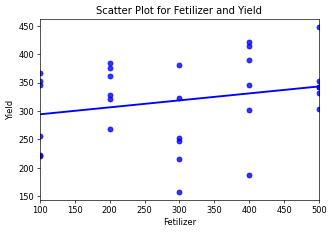

In [19]:
df16_133 = pd.read_excel('Xr16-133.xlsx')
_ = sns.regplot(x='Fetilizer', y= 'Yield', data = df16_133, color = 'b', ci = None)
plt.title('Scatter Plot for Fetilizer and Yield')
plt.xlabel('Fetilizer')
plt.ylabel('Yield')
plt.show()

According to the scatter plot, it seems to be a little linear relationship between Yield and Fetilizer.

In [20]:
# Fit regression model 
df16_result3 = smf.ols('Yield~ Fetilizer', data=df16_133).fit()

# Inspect the results
print(df16_result3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.772
Date:                Wed, 04 May 2022   Prob (F-statistic):              0.194
Time:                        04:17:12   Log-Likelihood:                -169.57
No. Observations:                  30   AIC:                             343.1
Df Residuals:                      28   BIC:                             345.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    281.8000     30.561      9.221      0.0

### (a)

In [21]:
# Inspect the results
b1_1 = df16_result3.params[1]
b0_1 = df16_result3.params[0]
print("Estimated model: y = %0.4f + %0.4f x" % (b0_1, b1_1))

Estimated model: y = 281.8000 + 0.1227 x


#### Interpretation
The slope is .123, which tells us that for each additional unit of fertilizer, corn yield increases on average by .123. The y-intercept is 281.7, which has no real meaning.

### (b)  
H0: β1 = 0  
H1: β1 != 0  
According to the table. The pvalue is 0.194 > alpha = 0.05.  
Thus, we cannot reject the null hypothesis at a significance level of 0.05.  
There is no evidence of a linear relationship between Fertilizer and Yield.  
### (c)

In [22]:
r2 = df16_result3.rsquared
print("r^2 = ", r2) # coefficient of determination

r^2 =  0.05952603868594741


5.95% of the variation in corn yield is explained by the variation in amount of fertilizer. 
### (d)
The model is too poor to be used to predict. (原因合理即可，eg (c)R square太低、(b)非線性)

### (Residual analysis)

In [23]:
# studentized residual
st133, data133, ss133 = sso.summary_table(df16_result3, alpha=0.05)
SD133 = data133[:, 10]

In [24]:
Normality(SD133)

Normality test for errors using Shapiro Test
 - H0: Errors are normally distributed.
 - H1: Errors are not normally distributed.

pvalue of Shapiro Test = 0.2068082094192505

Since p-value > 0.05, we do not reject H0 and we may conclude errors are normally distributed.


Homoscedasticity Test
 - H0: Homoscedasticity
 - H1: Heteroscedasticity



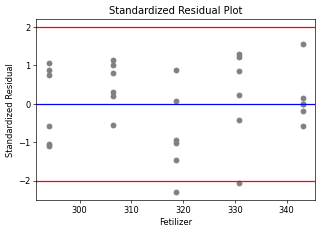

In [25]:
Homoscedasticity(data133, "Fetilizer")

According to the figure, we do not rejected H0.  
We can assume that the variation is constant and the mean is around 0.

In [26]:
Randomness(SD133)

Randomness Test using Runs Test
 - H0: Randomness exists.
 - H1: Randomness does not exist

runs =  19
n1 =  15
n2 =  16
Since both n1 and n2 < 20, we check the Run Test table.


After checking the Run Test table, we reject H0 if runs <= 10 or runs >=23.  
Since  10 < runs = 19 < 23, we do not reject H0 and we may conclude Randomness exists.

## 17.1 (20%)
### (散佈圖 2%, a, b, c, d, e, f, g, h, i 各2%)

In [27]:
df17_1 = pd.read_excel('Xr17-01.xlsx')
print('Head of dataset:')
display(df17_1.head())
print("Tail of dataset:")
display(df17_1.tail())


Head of dataset:


,Price,Lot size,Trees,Distance
0,105.4,41.2,24,42
1,91.2,44.8,5,71
2,183.3,21.3,72,43
3,93.8,43.9,58,14
4,207.5,57.7,52,12


Tail of dataset:


,Price,Lot size,Trees,Distance
55,27.9,40.0,52,84
56,103.5,46.6,26,70
57,107.0,23.2,11,83
58,51.6,46.4,53,44
59,133.4,32.1,55,98


Independent variable:  
X1: Lot size  
x2: Trees  
x3: Distance  
Dependent variable (y): Prcie

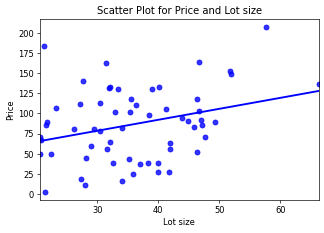

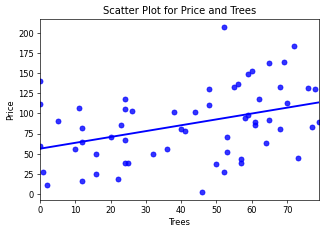

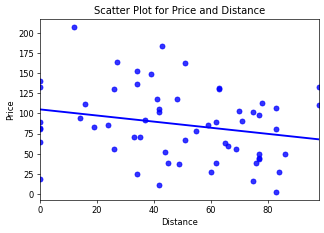

In [28]:
y_var = df17_1['Price'].values
xnames = df17_1.columns[1:]
for aname in xnames:
    x_var = df17_1[aname].values
    _ = sns.regplot(x = x_var, y = y_var, data = df17_1, color = 'b', ci = None)
    #_ = plt.plot(x, y, 'o', color = 'b')
    plt.xlabel(aname)
    plt.ylabel('Price')
    plt.title('Scatter Plot for Price and ' +aname)
    plt.show()


According to the scatter plot, all independet variables seem to have linear relationship with Price.

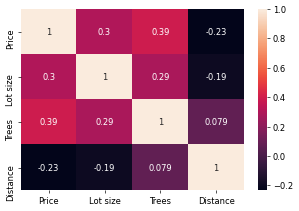

In [29]:
df17_1a = df17_1[df17_1.columns]
corr1 = df17_1a.corr()
_ = sns.heatmap(corr1, annot=True)

In [30]:
y_data = df17_1['Price']
X_data_ar = np.array([df17_1['Lot size'], df17_1['Trees'], df17_1['Distance']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df17_1.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
result_reg = olsmod.fit()
print(result_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     5.975
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00132
Time:                        04:17:13   Log-Likelihood:                -304.76
No. Observations:                  60   AIC:                             617.5
Df Residuals:                      56   BIC:                             625.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.3912     23.517      2.185      0.0

/Users/wuyunwei/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### (a)

In [31]:
# Inspect the results
b1_3 = result_reg.params[3]
b1_2 = result_reg.params[2]
b1_1 = result_reg.params[1]
b0_1 = result_reg.params[0]
print("Estimated model: y = %0.4f + %0.4f x1 + %0.4f x2 + %0.4f x3" % (b0_1, b1_1, b1_2, b1_3))

Estimated model: y = 51.3912 + 0.6999 x1 + 0.6788 x2 + -0.3784 x3


### (b)

In [32]:
print("standard error = ", result_reg.mse_resid ** 0.5)

standard error =  40.24352944532851


It is an estimate of the standard deviation of the error variable.

### (c)

In [33]:
r2 = result_reg.rsquared
print("r^2 = ", r2)

r^2 =  0.24247188773540485


24.25% of the variation in prices is explained by the model.

### (d)

In [34]:
r2_adj = result_reg.rsquared_adj
print("adjusted r^2 = ", r2_adj)

adjusted r^2 =  0.2018900245783729


 The coefficient of determination adjusted for degrees of freedom is .2019. It differs from  because it includes an adjustment for the number of independent variables.

### (e)  
H0: beta_1 = beta_2 = beta_3 = 0  
H1: At least one of the betas != 0

In [35]:
A = np.identity(len(result_reg.params))
A = A[1:,:]
print("F test = ", result_reg.f_test(A))

F test =  <F test: F=array([[5.97488309]]), p=0.0013153712505549735, df_denom=56, df_num=3>


Since p-value = 0.0013 < alpha = 0.05, we can reject H0.  
There is enough evidence to conclude that the model is valid.

### (f)  
b1 = .700; for each addition thousand square feet the price on average increases by .700 thousand dollars provided that the other variables remain constant.  
b2 = .679; for each addition tree the price on average increases by .679 thousand dollars provided that the other variables remain constant.  
b3 = –.378; for each addition foot from the lake the price on average decreases by .378 thousand dollars provided that the other variables remain constant.  


### (g)  
H0: βi = 0 for i = 1, 2, 3  
H1: βi ≠ 0 for i = 1, 2, 3

According to the OLS Regression Results Summary Table,   
i = 1: pvalue of lot size = 0.216 > 0.05. We do not reject H0.  
i = 2: pvalue of Trees    = 0.004 < 0.05. We reject H0.  
i = 3: pvalue of Distance = 0.058 > 0.05. We do not reject H0.  
Thus, only for the number of trees is there enough evidence to infer a linear relationship with price.

### (h)

In [36]:
x1 = [1, 40, 50, 25]
CI, PI = CI_PI_regression(X_data_ar, y_data, x1, 0.1)
print("Predicted sell = ", PI, "(thousand dollar)")

Predicted sell =  [35.497890144786126, 172.24017117301867] (thousand dollar)


### (i)

In [37]:
x1 = [1, 50, 10, 75]
CI, PI = CI_PI_regression(X_data_ar, y_data, x1, 0.1)
print("Estimated average price = ", CI, "(thousand dollar)")

Estimated average price =  [39.290885357615366, 90.3041360033556] (thousand dollar)


## 17.9 (15%)  
### (散佈圖 3%, a, b, c, d 各3%)¶

In [38]:
df17_9 = pd.read_excel('Xr17-09.xlsx')
print('Head of dataset:')
display(df17_9.head())
print("Tail of dataset:")
display(df17_9.tail())

Head of dataset:


/Users/wuyunwei/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,Test Score,Math Degree,Age,Income
0,73.9,77,52,44.4
1,59.4,48,32,49.0
2,64.6,33,50,52.6
3,59.8,25,43,39.6
4,58.8,25,40,40.7


Tail of dataset:


,Test Score,Math Degree,Age,Income
35,71.7,57,59,55.1
36,68.8,41,40,33.7
37,45.0,27,40,19.8
38,61.9,37,44,48.2
39,56.0,36,56,55.9


Independent variable:  
X1: Math Degree  
x2: Age  
x3: Income  
Dependent variable (y): Test Score

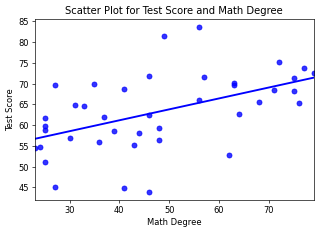

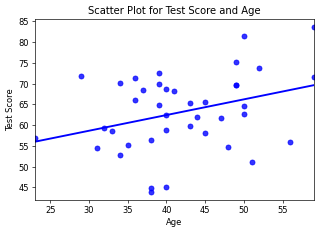

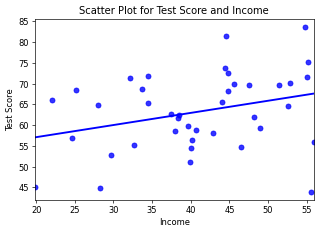

In [39]:
y_var = df17_9['Test Score'].values
xnames = df17_9.columns[1:]
for aname in xnames:
    x_var = df17_9[aname].values
    _ = sns.regplot(x = x_var, y = y_var, data = df17_9, color = 'b', ci = None)
    #_ = plt.plot(x, y, 'o', color = 'b')
    plt.xlabel(aname)
    plt.ylabel('Test Score')
    plt.title('Scatter Plot for Test Score and ' +aname)
    plt.show()


According to the scatter plot, all independet variables seem to have linear relationship with Test Score.

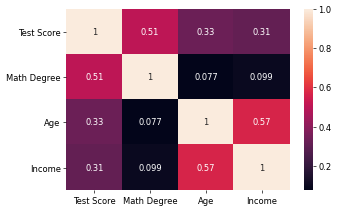

In [40]:
df17_9a = df17_9[df17_9.columns]
corr1 = df17_9a.corr()
_ = sns.heatmap(corr1, annot=True)

In [41]:
y_data = df17_9['Test Score']
X_data_ar = np.array([df17_9['Math Degree'], df17_9['Age'], df17_9['Income']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df17_9.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
result_reg = olsmod.fit()
print(result_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             Test Score   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     6.663
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00108
Time:                        04:17:13   Log-Likelihood:                -136.43
No. Observations:                  40   AIC:                             280.9
Df Residuals:                      36   BIC:                             287.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          35.6776      7.279      4.902      

/Users/wuyunwei/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### (a)

In [42]:
# Inspect the results
b1_3 = result_reg.params[3]
b1_2 = result_reg.params[2]
b1_1 = result_reg.params[1]
b0_1 = result_reg.params[0]
print("Estimated model: y = %0.4f + %0.4f x1 + %0.4f x2 + %0.4f x3" % (b0_1, b1_1, b1_2, b1_3))

Estimated model: y = 35.6776 + 0.2475 x1 + 0.2448 x2 + 0.1333 x3


### (b)  
H0: beta_1 = beta_2 = beta_3 = 0  
H1: At least one of the betas != 0

In [43]:
A = np.identity(len(result_reg.params))
A = A[1:,:]
print("F test = ", result_reg.f_test(A))

F test =  <F test: F=array([[6.66312516]]), p=0.0010769247208052384, df_denom=36, df_num=3>


Since p-value = 0.0011 < alpha = 0.05, we can reject H0.  
There is enough evidence to conclude that the model is valid.

### (c)  
b1 = .247; for each one percentage point increase in the proportion of teachers with mathematics degrees the test score increases on average by .247 provided the other variables are constant.  
b2 = .245; for each one year increase in mean age test score increases on average by .245 provided the other variables are constant .  
b3 = .135; for each one thousand dollar increase in salary test score increases on average by .135 provided the other variables are constant.  
 
H0: βi = 0 for i = 1, 2, 3  
H1: βi ≠ 0 for i = 1, 2, 3

According to the OLS Regression Results Summary Table,   
i = 1: pvalue of Math Degree = 0.001 < 0.05. We reject H0.  
i = 2: pvalue of Age         = 0.195 > 0.05. We do not reject H0.  
i = 3: pvalue of Income      = 0.389 > 0.05. We do not reject H0.  
Thus, the proportion of teachers with at least one mathematics degree is linearly related to test scores and the other two variables appear to be unrelated.

### (d)

In [44]:
x1 = [1, 50, 43, 48.3]
CI, PI = CI_PI_regression(X_data_ar, y_data, x1, 0.05)
print("Predicted Test Score = ", PI )

Predicted Test Score =  [49.01506162299047, 81.02022674886392]


## 17.15 (12%)  
### (散佈圖 3%, a, b, c, 各3%)¶

In [45]:
df17_15 = pd.read_excel('Xr17-15.xlsx')
print('Head of dataset:')
display(df17_15.head())
print("Tail of dataset:")
display(df17_15.tail())

Head of dataset:


,DEFINITE,AGE,EDUC,INCOME
0,10,34,13,127500
1,10,58,12,16000
2,10,39,16,32500
3,5,49,12,23500
4,10,72,16,82500


Tail of dataset:


,DEFINITE,AGE,EDUC,INCOME
1657,6,33,12,27500
1658,2,28,12,8750
1659,8,39,13,42500
1660,8,64,12,175000
1661,1,34,10,1500


Independent variable:  
X1: Age  
x2: Education  
x3: Income  
Dependent variable (y): Definite

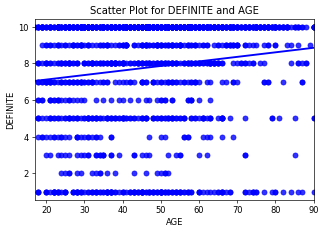

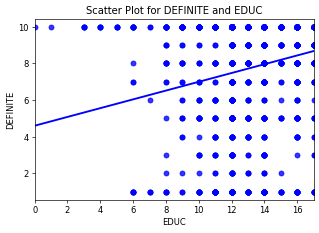

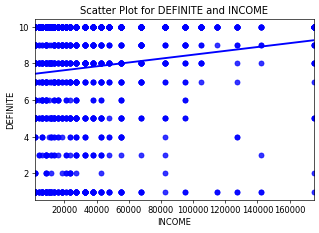

In [46]:
y_var = df17_15['DEFINITE'].values
xnames = df17_15.columns[1:]
for aname in xnames:
    x_var = df17_15[aname].values
    _ = sns.regplot(x = x_var, y = y_var, data = df17_15, color = 'b', ci = None)
    #_ = plt.plot(x, y, 'o', color = 'b')
    plt.xlabel(aname)
    plt.ylabel('DEFINITE')
    plt.title('Scatter Plot for DEFINITE and ' +aname)
    plt.show()


According to the scatter plot, all independet variables seem to have little linear relationship with DEFINITE.

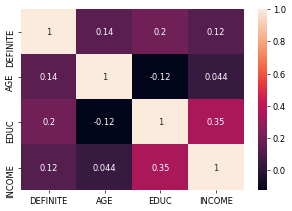

In [47]:
df17_15a = df17_15[df17_15.columns]
corr1 = df17_15a.corr()
_ = sns.heatmap(corr1, annot=True)

In [48]:
y_data = df17_15['DEFINITE']
X_data_ar = np.array([df17_15['AGE'], df17_15['EDUC'], df17_15['INCOME']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df17_15.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
result_reg = olsmod.fit()
print(result_reg.summary())

                            OLS Regression Results                            
Dep. Variable:               DEFINITE   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     41.92
Date:                Wed, 04 May 2022   Prob (F-statistic):           4.15e-26
Time:                        04:17:14   Log-Likelihood:                -4116.4
No. Observations:                1662   AIC:                             8241.
Df Residuals:                    1658   BIC:                             8263.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0230      0.461      6.553      0.0

/Users/wuyunwei/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### (a)

In [49]:
# Inspect the results
b1_3 = result_reg.params[3]
b1_2 = result_reg.params[2]
b1_1 = result_reg.params[1]
b0_1 = result_reg.params[0]
print("Estimated model: y = %0.4f + %0.4f x1 + %0.4f x2 + %0.4f x3" % (b0_1, b1_1, b1_2, b1_3))

Estimated model: y = 3.0230 + 0.0289 x1 + 0.2461 x2 + 0.0000 x3


### (b)  
H0: beta_1 = beta_2 = beta_3 = 0  
H1: At least one of the betas != 0

In [50]:
A = np.identity(len(result_reg.params))
A = A[1:,:]
print("F test = ", result_reg.f_test(A))

F test =  <F test: F=array([[41.91820083]]), p=4.151461915530292e-26, df_denom=1.66e+03, df_num=3>


Since p-value = 0 < alpha = 0.05, we can reject H0.  
There is enough evidence to conclude that the model is valid.

### (c)   
H0: βi = 0 for i = 1, 2, 3  
H1: βi ≠ 0 for i = 1, 2, 3

According to the OLS Regression Results Summary Table,   
i = 1: pvalue of Age       = 0 < 0.05. We reject H0.  
i = 2: pvalue of Education = 0 < 0.05. We reject H0.  
i = 3: pvalue of Income    = 0.086 > 0.05. We do not reject H0.  
Thus, AGE and EDUC are linearly related to DEFINITE and INCOME isnt.